## Композиции моделей: бэггинг, случайный лес

Будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). 

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [9]:
data = pd.read_csv('diabetes.csv')

In [10]:
data.shape

(768, 9)

In [11]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Посмотрим на распределение целевой переменной

In [13]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: >

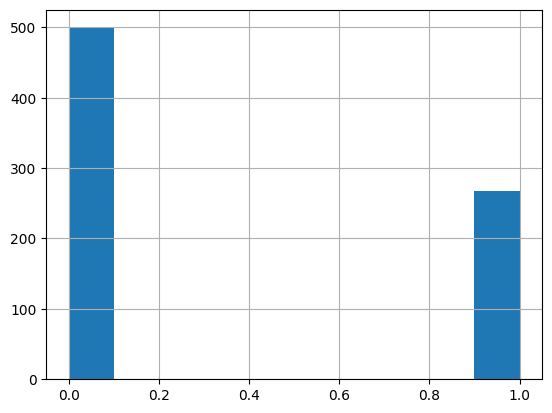

In [14]:
data['Outcome'].hist()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

✅ Разделим данные на признаки и целевую переменную

In [15]:
y = data['Outcome']
X = data.drop('Outcome', axis = 1)

✅ Разобьем датасет на тренировочную и тестовую части в отношении 70:30

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

✅ Обучите BaggingClassifier на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

*Создадим функцию для подсчета метрик:*

In [17]:
def calc_all_metrics(y_pred, y_test):
    return (f'Acccuracy: {accuracy_score(y_test, y_pred)}\n'
           f'Precision: {precision_score(y_test, y_pred)}\n'
           f'Recall: {recall_score(y_test, y_pred)}\n'
           f'AUC_ROC: {roc_auc_score(y_test, y_pred)}')

**BaggingClassifier**

In [18]:
bagging_clf = BaggingClassifier(n_estimators = 50)

bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
print(f'Bagging Classifier:\n{calc_all_metrics(y_pred_bagging, y_test)}')

Bagging Classifier:
Acccuracy: 0.8181818181818182
Precision: 0.7580645161290323
Recall: 0.6351351351351351
AUC_ROC: 0.7697968669306249


✅ Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

**Random Forest**

In [19]:
rand_forest_clf = RandomForestClassifier(n_estimators = 50)

rand_forest_clf.fit(X_train, y_train)
y_pred_rf = rand_forest_clf.predict(X_test)
print(f'Random Forest:\n{calc_all_metrics(y_pred_rf, y_test)}')

Random Forest:
Acccuracy: 0.7532467532467533
Precision: 0.6491228070175439
Recall: 0.5
AUC_ROC: 0.6863057324840764


In [20]:
np.sum(y_pred_bagging == y_pred_rf)/len(y_pred_rf)

0.9004329004329005

✅ Какая из двух построенных моделей показала себя лучше?

**Заметим, что модели выдают очень похожие предсказания.**

✅ Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` 
* `'min_samples_leaf'`

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

Строим графики зависимости AUC-ROC

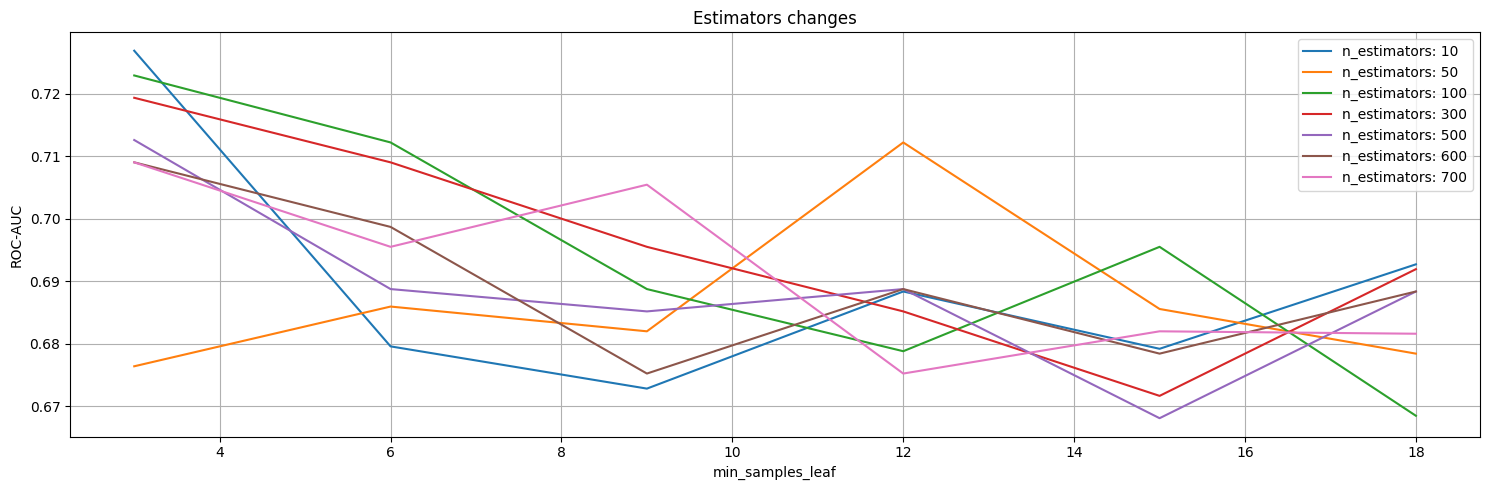

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 5))

n_trees = [10, 50, 100, 300, 500, 600, 700]
leafes = list(np.arange(3, 20, 3))

for i in n_trees:
    score = []
    for j in leafes:
        rand_forest_clf = RandomForestClassifier(n_estimators = i, min_samples_leaf = j)
        rand_forest_clf.fit(X_train, y_train)
        y_pred = rand_forest_clf.predict(X_test)
        score.append(roc_auc_score(y_test, y_pred))
    ax1.plot(leafes, score)
    
ax1.set(xlabel = 'min_samples_leaf', ylabel = 'ROC-AUC', title = 'Estimators changes')
ax1.legend([f'n_estimators: {x}' for x in n_trees], loc ='upper right', frameon = True)
ax1.grid(True)

plt.tight_layout()

Строим тепловую карту 

*Строить тепловую карту удобнее, если использовать поиск по сетке.*

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
estimators = [10, 50, 100, 300]
min_samples_leaf = list(np.arange(1, 20, 5))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf}

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring = 'roc_auc', cv = 3)
clf.fit(X_train, y_train)

best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_score = clf.best_score_

In [24]:
print('Оптимальное количество деревьев', best_n_estimators_value)
print('Оптимальное количество листьев', best_min_samples_leaf)
print('AUC-ROC', best_score)

Оптимальное количество деревьев 50
Оптимальное количество листьев 16
AUC-ROC 0.8276530931565257


(Преобразовываем для построения тепловой карты)

In [25]:
estimators = clf.cv_results_['param_n_estimators'].data
min_samples_leaf = clf.cv_results_['param_min_samples_leaf'].data

In [26]:
import seaborn as sns

In [27]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


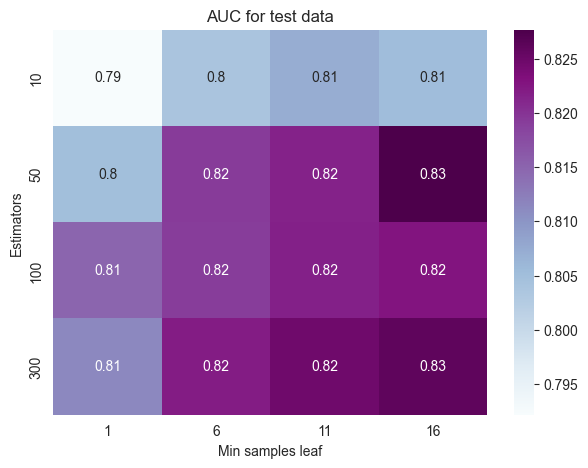

In [28]:
sns.set_style('white')
plt.figure(figsize = (7,5))

data = pd.DataFrame(data={'Estimators': estimators, 'Min samples leaf': min_samples_leaf,
                    'AUC': clf.cv_results_['mean_test_score']})
data = data.pivot(index = 'Estimators', columns = 'Min samples leaf', values ='AUC')

sns.heatmap(data, annot=True, cmap = "BuPu").set_title('AUC for test data')

plt.show()

✅ Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [29]:
# Обучаем лучшую модель
rand_clf = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 11, random_state = 0)
rand_clf.fit(X_train, y_train)

# Посмотрим на важность признаков
importances = rand_clf.feature_importances_

In [30]:
features = pd.DataFrame({"feature": X.columns, 'importance': importances})
features.sort_values(by = 'importance', ascending = False)

,feature,importance
1,Glucose,0.360647
5,BMI,0.174279
7,Age,0.173524
6,DiabetesPedigreeFunction,0.082256
0,Pregnancies,0.068168
4,Insulin,0.054707
3,SkinThickness,0.050826
2,BloodPressure,0.035593


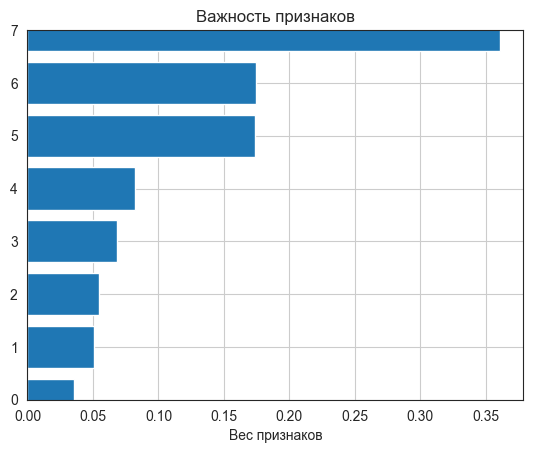

In [31]:
#Пример того, как можно построить bar plot

indices = np.argsort(importances)
columns = data.columns[:-1]

plt.figure()
plt.title("Важность признаков")
plt.barh(range(X.shape[1]), importances[indices])

plt.ylim([0,X.shape[1]-1])
plt.xlabel('Вес признаков')
plt.gca().grid(True)
plt.show()